# Автокорреляция и стационарность

## Вопрос 3

В приложенном файле — данные по ежемесячному уровню производства молока в фунтах на одну корову:

`monthly-milk-production.csv`

Загрузите ряд, например, так:

```python
milk = pd.read_csv('monthly-milk-production.csv',';', index_col=['month'], 
  parse_dates=['month'], dayfirst=True)
```
и постройте его график. Какой из приведённых ниже графиков у вас получился?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
milk = pd.read_csv('monthly-milk-production.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

milk.head()

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


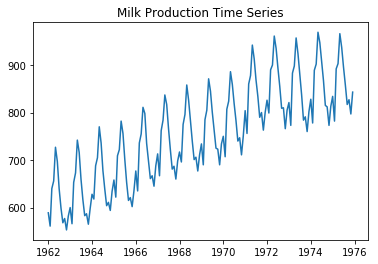

In [3]:
plt.plot(milk.milk)
plt.title('Milk Production Time Series')
plt.show()

## Вопрос 4

Примените к ряду из предыдущего вопроса критерий Дики-Фуллера. Это делается так:

```python
import statsmodels.api as sm
sm.tsa.stattools.adfuller(ряд)
```

Чему равен полученный достигаемый уровень значимости? Округлите до двух знаков после десятичной точки.

In [4]:
import statsmodels.api as sm

C:\Users\u6335\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
print('Dickey-Fuller test p-value =', round(sm.tsa.stattools.adfuller(milk.milk)[1], 2))

Dickey-Fuller test p-value = 0.63


## Вопрос 5

 
Часто, когда вы имеете дело с величинами, представляющими собой сумму значений показателя за каждый день или за каждый рабочий день, имеет смысл перед началом прогнозирования поделить весь ряд на число дней в периоде. Например, если поделить ряд с объёмом производства молока на одну корову на число дней в месяце, полученная величина будет меняться более плавно, и для неё легче будет построить прогнозирующую модель.

Корректно определить число дней в месяце позволяет функция `monthrange` из пакета `calendar`. Используйте её для того, чтобы вычислить новый показатель — среднее дневное число полученного молока на одну корову. Постройте график этого ряда и убедитесь, что он стал более гладким.

В качестве ответа введите сумму значений полученного показателя за весь период; округлите до двух знаков после десятичной точки.

In [6]:
from calendar import monthrange

In [7]:
milk['month_size'] = milk.index.to_series().apply(lambda x: monthrange(x.year, x.month)[1])

milk['milk_per_day'] = milk.milk / milk.month_size

milk.head()

,milk,month_size,milk_per_day
month,,,
1962-01-01,589,31,19.000000
1962-02-01,561,28,20.035714
1962-03-01,640,31,20.645161
1962-04-01,656,30,21.866667
1962-05-01,727,31,23.451613


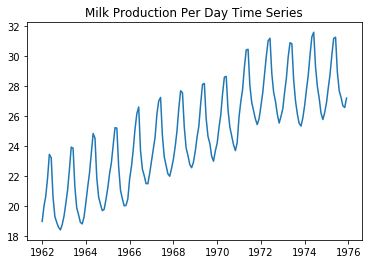

In [8]:
plt.plot(milk.milk_per_day)
plt.title('Milk Production Per Day Time Series')
plt.show()

In [9]:
print('Sum for The Period =', round(sum(milk['milk_per_day']), 2))

Sum for The Period = 4166.33


# Прогнозирование временных рядов

## Вопрос 7

Для ряда со средним дневным количеством молока на корову из предыдущего вопроса давайте с помощью критерий Дики-Фуллера подберём порядок дифференцирования, при котором ряд становится стационарным.

Дифференцирование можно делать так:

`milk.daily_diff1 = milk.daily - milk.daily.shift(1)`

Чтобы сделать сезонное дифференцирование, нужно изменить значение параметра у функции shift:

`milk.daily_diff12 = milk.daily - milk.daily.shift(12)`

При дифференцировании длина ряда сокращается, поэтому в части строк в новой колонке значения будут не определены (NaN). Подавая полученные столбцы на вход критерию Дики-Фуллера, отрезайте неопределённые значения, иначе вы получите неопределённый достигаемый уровень значимости.

Итак, какое дифференцирование делает ряд стационарным?

In [23]:
milk.daily_diff1 = milk.milk_per_day - milk.milk_per_day.shift(1)

print('Diff 1 Dickey-Fuller test p-value =', round(sm.tsa.stattools.adfuller(milk.daily_diff1.values[1:])[1], 2))

Diff 1 Dickey-Fuller test p-value = 0.06


In [27]:
milk.daily_diff12 = milk.milk_per_day - milk.milk_per_day.shift(12)

print('Diff Seasonal Dickey-Fuller test p-value =', round(sm.tsa.stattools.adfuller(milk.daily_diff12.values[12:])[1], 2))

Diff Seasonal Dickey-Fuller test p-value = 0.22


In [34]:
milk.daily_diff_double = milk.daily_diff12 - milk.daily_diff12.shift(1)

print('Double Dickey-Fuller test p-value =', round(sm.tsa.stattools.adfuller(milk.daily_diff_double.values[13:])[1], 2))

Double Dickey-Fuller test p-value = 0.0


## Вопрос 8

Для стационарного ряда из предыдущего вопроса (продифференцированного столько раз, сколько вы посчитали нужным) постройте график автокорреляционной функции. Это можно cделать так:

`import statsmodels.api as sm`

`sm.graphics.tsa.plot_acf(ряд.values.squeeze(), lags=50)`

Исходя из этого графика, какое начальное приближение вы предложили бы для параметра QQ в модели SARIMA?

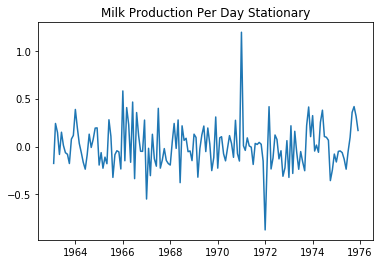

In [75]:
plt.plot(milk.daily_diff_double[13:])
plt.title('Milk Production Per Day Stationary')
plt.show()

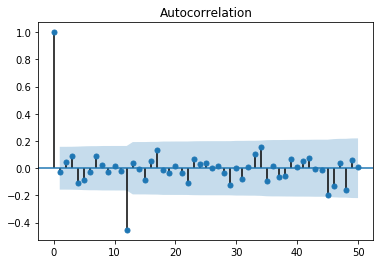

In [82]:
sm.graphics.tsa.plot_acf(milk.daily_diff_double[13:].values.squeeze(), lags=50)

In [86]:
print('Ответ: 1 (12/12)')

Ответ: 1 (12/12)


## Вопрос 9

Для того же ряда, что и в предыдущем вопросе, постройте график частичной автокорреляционной функции. Это можно сделать так:

`sm.graphics.tsa.plot_pacf(ряд.values.squeeze(), lags=50)`

Исходя из этого графика, какое начальное приближение вы предложили бы для параметра p в модели SARIMA?

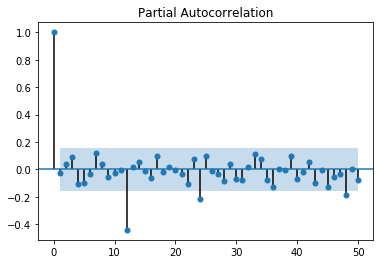

In [83]:
sm.graphics.tsa.plot_pacf(milk.daily_diff_double[13:].values.squeeze(), lags=50)

In [85]:
print('Ответ: 0')

Ответ: 0
